In [2]:
"""
File for modelling full sampling procedure, with rotation rate, voltage fitting, profiling speed, etc.

"""

import numpy as np
import pandas as pd
from scipy.io import netcdf
from scipy.io import loadmat, savemat
from scipy import signal
from datetime import datetime
import matplotlib.pyplot as plt
import random as rand
import pyIGRF
from src.spectral_processing import *
import os
import warnings




%load_ext autoreload
%autoreload 2

cdip_color='#F5B958'
red_color = '#D81159'
gray_color= '#2E2836'

In [6]:
# Step 1 Pick a wave spectra


def load_CDIP(fname):
    
    #fname = "/Volumes/TFO-exFAT-1/TFO/LCDRI/CDIPwaverider229/229p1_d01.nc";
    nc = netcdf.NetCDFFile(fname, 'r', mmap=False) #Not sure why I need to do mmap = False but it gets rid of a warning
    time = nc.variables['waveTime'][:]
    Hs = nc.variables['waveHs'][:]
    energy_density = nc.variables['waveEnergyDensity'][:]
    wave_freq = nc.variables['waveFrequency'][:]
    #dtimes = datetime(time, 'convertfrom', 'posixtime');
    nc.close()
    #plt.figure()
    #plt.plot(time[0:10], Hs[0:10])
    
    return(np.array(time.data), np.array(wave_freq.data), np.array(energy_density.data))




In [25]:
# Step 2: Make a record of x-y-z positions of float

def apex_sampling_grid(start_z, end_z, prof_speed, u_prof, v_prof, sample_rate=1):
    """
    Inputs:
        start_z: Initial depth

        end_z: Final Depth

        prof_speed: Profiling spped (m/s)

        Sample_rate: Sampling frequency (defauly 1Hz for Em-APEX float)
        
    Outputs:
        
    """
    t_length = np.abs(np.abs(end_z-start_z)/prof_speed)
    num_samples = np.abs(int(t_length*sample_rate))
    z_range = np.linspace(start_z, end_z, num_samples)
    t_array = np.linspace(0, t_length, num_samples)

    #Get the z-position
    em_z = t_array*prof_speed+start_z

    #Get the x-position
    em_x, em_y = get_xy_position(u_prof, v_prof)
    
    return(em_x, em_y, em_z)

def get_xy_position(u_prof, v_prof):
    """
        Returns x-y-position of float given some horizontal-velocity-profile
    """
    em_x = np.zeros(len(u_prof))
    em_y = np.zeros(len(v_prof))
    for i in range(len(u_prof)):
        em_x[i] = np.trapz(u_prof[:i])
        em_y[i] = np.trapz(v_prof[:i])
        
    return(em_x, em_y)
        

In [26]:
# Step 2: Build a wave based timeseries of u. Add to it the mean u profile

def build_u_timeseries(em_x, em_y, em_z, input_spectra, f, theta_spec, n_iter, noise = 0.008, fy=1, fz=1):

    fs = 1
    u_store = np.zeros((n_iter, len(em_x)))
    v_store = np.zeros((n_iter, len(em_x)))

    t_range = np.linspace(0, len(em_x), len(em_x))
    #Number of iterations to run
    #zeta_store = np.zeros((n_iter, len(t_range)))
    t = 0
    x = 0
    #Try interpolating the spectra
    #f_target = np.linspace(f[0], f[-1], 128)
    #input_spectra = np.interp(f_target, f, input_spectra)
    #f= f_target
    
    #theta_spec = np.ones(len(f))*-1*np.pi/4


    #plt.figure()
    #plt.loglog(f_target, )
    for jj in range(0, n_iter):
        for i in range(0, len(f-1)):#:#len(f)-1:
            freq = f[i]
            if i == 0:
                df = f[1]-f[0]
            elif i == len(f)-1:
                df = f[i]-f[i-1]
            else:
                df = (f[i+1]-f[i-1])/2
            omega = 2*np.pi*freq;
            k = np.square(omega)/9.8
            
            #This is assuming theta is angle CCW from east
            kx = k * np.cos(theta_spec[i])
            ky = k * np.sin(theta_spec[i])
            
            #Is there a 2 in here or not?
            a = np.sqrt(input_spectra[i]*df*2) # Is this the right conversion to wave amplitude? 

            #Randomize phase
            phi = rand.random()*2*np.pi

             
            beta = (fy/fz)*np.sin(theta_spec[i])
            u = np.sqrt(1+beta**2)*a*omega*np.cos(kx*em_x+ky*em_y-omega*t_range + phi)*np.exp(-k*em_z)*np.cos(theta_spec[i])
            v = a*omega*np.cos(ky*em_y+kx*em_x-omega*t_range + phi)*np.exp(-k*em_z)*np.sin(theta_spec[i])
            
            #zeta = a*np.cos(k*x-omega*t_range + phi)
            #print(u)
            u_store[jj, :] = u_store[jj, :] + u
            v_store[jj, :] = v_store[jj, :] + v
    #how do we choose the amplitude for each frequency?



    ## Add white noise
    
    #First generate a white noise with the std of an EM-APEX float white noise situation
    #TO DO: Check if "uncertainty of 0.8-1.5 cm/s" means that's 1 Std or rms or what
    mean = 0
    std = 0.01 
    num_samples = len(u_store[:, 0])*len(u_store[0, :])
    rand_samples = noise*np.random.normal(loc = 0, scale = 1, size = num_samples)

    rand_samples = rand_samples.reshape((len(u_store[:, 0]), len(u_store[0, :])))
    u_noise = u_store + rand_samples
    v_noise = v_store + rand_samples
   

    return(u_noise, v_noise)




In [27]:
#Step 3 transform into voltages in x-y directions:




#Step 4 rotate each channel's position in time
#initial phase offset of channel 1
def get_channel_angs(t_length, rotation_rate, phi=0):

    ch1_angs = np.linspace(0, int(t_length), int(t_length))*rotation_rate*2*np.pi+phi
    
    #ch1_angs = ch1_angs + 0.01*np.random.normal(loc = 0, scale = 1, size = len(ch1_angs))*2*np.pi   #Add some white noise to ch1 angles to simulate non-constant rotation rate
    
    #rand_samples = 0.1*np.random.normal(loc = 0, scale = 1, size = int(t_length))

    #ch1_angs = ch1_angs + rand_samples
    ch2_angs = ch1_angs - np.pi/2 #Add 90deg for channel2
    
    
                           
    return(ch1_angs, ch2_angs)

In [28]:

#For start depth study, used up speed = 0.11, rate=0.07, down_speed = 0.15, rate=0.11
#For rot_rate study, used start_depth=0, speed=0.11 for both up and down
#For prof_speed, used start_depth=0, rot_rate = 0.1
#For each parameter, run a series of simulations

#Load a wave spectra
#fname = "/Users/jamesstadler/Documents/UW/TFO/Data/221p1_rt.nc"
def run_simulation(noise):
    fname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/229p1_d01.nc"
    [times, f, spectra] = load_CDIP(fname)
    base_spectra = np.nanmean(spectra[450:465, :], 0)
    uxt_starttime = 1491226592.2198906
    kk_arr = [0.0001, 0.0005, 0.001, 0.0025, 0.005, 0.0075, 0.01, 0.0167, 0.025, 0.05, 0.06, 0.075, 0.1, 0.25, 0.5, 0.75, 1]
    kiteration = 0
    for kk in kk_arr:
        kiteration = kiteration+1
        uxt_base = uxt_starttime+1000*kiteration
        test_spectra = kk*base_spectra
        #plt.figure()
        #plt.loglog(f, test_spectra)
        start_depth = 8
        rot_rate = 0.11
        speed = .15
        check_count=0
        #plt.loglog(f, test_spectra)
        for i in range(2):
            #if i==0:
            ##    up = True
            #else:
            #    up=False
            uVpc = 1e6 * (10e-3 / (2**24))

            alpha2 = 1.95
            alpha1 = alpha2 - np.pi/2
            #Run it all

            #Define some input conditions
            #if up:
            #    start_z = 80
            #    end_z = start_depth
            #    prof_speed = -speed
            #    rotation_rate = rot_rate

            #else:
            start_z = 80
            end_z = start_depth
            prof_speed = -speed
            rotation_rate = rot_rate

            sample_rate = 1

            #Define some mean velocitiy profile
            t_length = np.abs((end_z-start_z)/prof_speed)
            num_samples = np.abs(int(t_length*sample_rate))
            z_range = np.linspace(start_z, end_z, num_samples)
            u_prof = 0.1*np.ones(int(t_length))#np.cos(z_range*2*np.pi/np.max(z_range))
            v_prof = 0.1*np.ones(int(t_length))#np.cos(z_range*2*np.pi/np.max(z_range))


            #build grid
            [em_x, em_y, em_z] = apex_sampling_grid(start_z, end_z, prof_speed, u_prof, v_prof)


            #Lets make a fake theta_spec for now:
            #Send all the waves to the southeast.
            theta_spec = np.ones(len(f))*-1*np.pi/4

            #Number of simulations to run
            n_iter = 20
            for iteration in range(n_iter):
                [u_store, v_store] = build_u_timeseries(em_x, em_y, em_z, test_spectra, f, theta_spec, 1, noise)

                #Add the mean profile
                u_store = u_store + u_prof
                v_store = v_store + v_prof

                #u_store = u_prof
                #v_store = v_prof


                #u_store = u_prof
                #v_store = v_prof
                #Step 3 get voltages
                avg_lat = 33.474764
                avg_lon = -119.288591

                [Bx, By, Bz, _] = pyIGRF.calculate.igrf12syn(2017.221917808219, 1, 0, avg_lat, avg_lon)
                fz=-np.nanmean(Bz);
                esep1 = (8+5/8)*0.0254 # m
                esep2 = (8+5/8)*0.0254 # m
                c1 = 0.5 
                Vx = fz*v_store*-1*esep1*(1+c1)/1000
                Vy = -fz*u_store*-1*esep1*(1+c1)/1000


                #Step 4 get the angular orientation of the float and convert voltages channel 1 and channel 2 components
                ch1_angs, ch2_angs = get_channel_angs(t_length, rotation_rate)

                #Rotate from magnetometer coordinates
                #Vxr = Vx*np.cos(alpha1)+Vy*np.sin(alpha1)
                #Vyr = Vx*np.sin(alpha1)-Vy*np.cos(alpha1)

                E1 = np.cos(ch1_angs+alpha1)*Vx + np.sin(ch1_angs+alpha1)*Vy
                E2 = -np.cos(ch1_angs+alpha1)*Vy + np.sin(ch1_angs+alpha1)*Vx

                #E1 = Vx
                #E2 = Vy

                #Step 5 add random low frequency offset
                xs = np.linspace(0, int(t_length), int(t_length))
                offset = -200-.1*xs + 8*(10**-9)*(xs**2) - 8*(10**-8)*(xs**3)
                #offset = 0
                E1 = E1 #+ offset
                E2 = E2 #+ offset

                E1=(E1/uVpc)+2**23
                E2=(E2/uVpc)+2**23


                #Angles are in magnetometer coordinates
                tilt_ang = np.pi/2
                HX = np.cos(ch1_angs)*98.6+513.9*np.cos(tilt_ang)
                ###NEED TO O###
                HY = np.sin(ch1_angs)*104.2+420

                randomized_HX = HX+0.01*HX*np.random.normal(loc = 0, scale = 1, size = len(HX))
                randomized_HY = HY+0.01*HY*np.random.normal(loc = 0, scale = 1, size = len(HX))

                if check_count==1:
                    plt.figure()
                    plt.subplot(121)
                    plt.plot(randomized_HX)
                    plt.subplot(122)
                    plt.plot(HX)
                    check_count+=1

                #Now step 6, save it as fake EM data, and run it through the normal pipeline

                #Need to save lat-lon data, Also time data


                uxt = uxt_base+xs
                #if up:
                #    E1 = np.flip(E1)
                #    E2 = np.flip(E2)
                #    HX = np.flip(HX)
                #    HY = np.flip(HY)
                #    P = np.flip(z_range)
                    #xs = np.flip(xs)
                    #uxt = np.flip(uxt)

                EFR = {"E1": E1, "E2": E2, "HX": np.expand_dims(randomized_HX, axis=0), "HY": np.expand_dims(randomized_HY, axis=0), "HZ": np.zeros((1, int(t_length))), "UXT":np.expand_dims(uxt, axis=0), "AGE": np.zeros((1, int(t_length))), "SEQNO":np.expand_dims(xs, axis=0)}

                CTD = {"P": np.expand_dims(z_range, axis=0), "UXT":np.expand_dims(uxt, axis=0)}


                GPS = {"LAT": np.array([[avg_lat]]), "LON": np.array([[avg_lon]]), "UXT_GPS": np.array([[uxt_starttime]])}


                base_savename = "/Users/jamesstadler/Documents/UW/TFO/Data/Simulations/minimum_wave_height/"


                #if up:
                savemat(base_savename+"6666g/dec/ema-6666g-0002-hf-"+str(kiteration)+"-iter-"+str(iteration)+"-efr.mat", EFR)
                savemat(base_savename+"6666g/dec/ema-6666g-0002-hf-"+str(kiteration)+"-iter-"+str(iteration)+"-gps.mat", GPS)
                savemat(base_savename+"6666g/dec/ema-6666g-0002-hf-"+str(kiteration)+"-iter-"+str(iteration)+"-ctd.mat", CTD)

                #if not up:
                #   savemat(base_savename+"down/6666g/dec/ema-6666g-0001-hf-"+str(kk)+"-iter-"+str(iteration)+"-efr.mat", EFR)
                #    savemat(base_savename+"down/6666g/dec/ema-6666g-0002-hf-"+str(kk)+"-iter-"+str(iteration)+"-gps.mat", GPS)
                #    savemat(base_savename+"down/6666g/dec/ema-6666g-0001-hf-"+str(kk)+"-iter-"+str(iteration)+"-ctd.mat", CTD)

In [82]:
#warnings.filterwarnings('ignore')
#Run the simulation for a series of velocity uncertainities, then put all those Hs measurements in 
# a pandas array for plotting in the next cell
fname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/229p1_d01.nc"
[times, f, spectra] = load_CDIP(fname)
base_spectra = np.nanmean(spectra[450:465, :], 0)


kk_arr = [0.0001, 0.0005, 0.001, 0.0025, 0.005, 0.0075, 0.01, 0.0167, 0.025, 0.05, 0.06, 0.075, 0.1, 0.25, 0.5, 0.75, 1]
noise_levels = [0.001, 0.005, 0.008, 0.01, 0.0115, 0.015, 0.018, 0.025, 0.035, 0.045] # These are m/s
df = pd.DataFrame(columns = ['Hs', 'Hs_stdev'])
base_savename = "/Users/jamesstadler/Documents/UW/TFO/Data/Simulations/minimum_wave_height/"
for noise in noise_levels:
    run_simulation(noise)
    [spec_store_sorted, time_store_sorted, uncertainty_store_sorted, up_down_store_sorted, loc_store_sorted, prof_store_sorted, fwindow] = process_files(base_savename)
    spec_store_sorted_new_corr = add_hf_tail(spec_store_sorted[:, 1, :], fwindow)
    [Hs,lower,upper] = sig_wave_height(fwindow, np.transpose(spec_store_sorted_new_corr))
    Hs_mean = []
    Hs_stdev = []
    last_ind = 0
    for i in range(len(kk_arr)):
        inds = np.where(time_store_sorted[last_ind+1]==time_store_sorted)[0]
        Hs_mean = np.append(Hs_mean, np.nanmean(Hs[inds]))
        Hs_stdev = np.append(Hs_stdev, np.nanstd(Hs[inds]))
        last_ind = inds[-1]
        
    
    df2 = pd.DataFrame(data = [[Hs_mean, Hs_stdev]], index = [str(noise)], columns = ['Hs', 'Hs_stdev'])
    df = pd.concat([df, df2])
    #np.delete(time_store_sorted, inds)
    

Min Hs =  0.6046110024028403


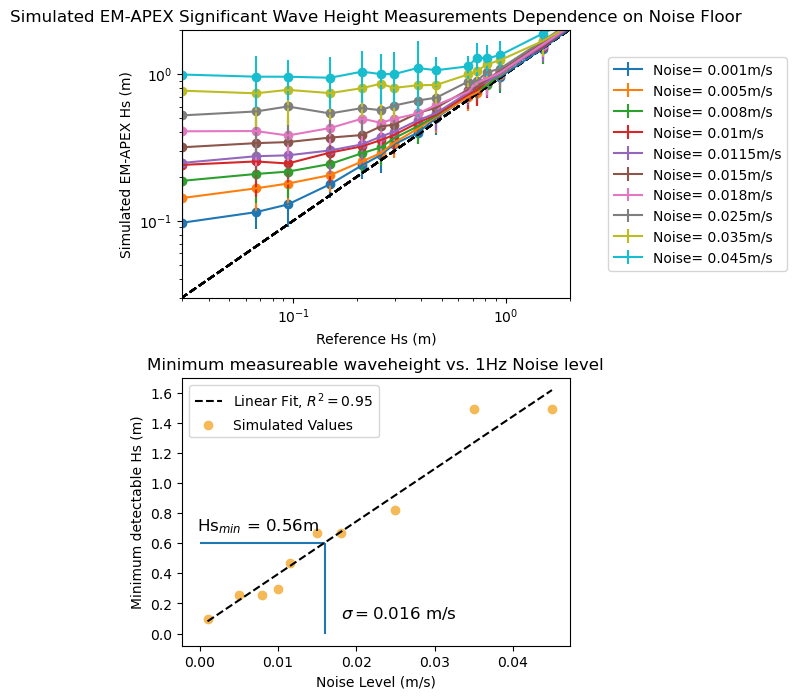

In [83]:
#PLot the dependence of 

warnings.filterwarnings('ignore')
Hs_cdip = 4*np.sqrt(np.trapz(np.tile(kk_arr, (64, 1)).T*np.tile(base_spectra, (len(kk_arr), 1)), x=f))
#noise=0.016
#Minimum significant wave height is:
#agreement_inds = np.where(df['Hs'][str(noise)]-2*df['Hs_stdev'][str(noise)]<Hs_cdip)[0]
#min_Hs = Hs_cdip[agreement_inds[0]]
#print("Min Hs = ", min_Hs,"m")
min_Hs_store = np.array([])
for noise in noise_levels:
    #Minimum significant wave height is:
    agreement_inds = np.where(df['Hs'][str(noise)]-2*df['Hs_stdev'][str(noise)]<Hs_cdip)[0]
    min_Hs_store = np.append(min_Hs_store, Hs_cdip[agreement_inds[0]])
    #print("Min Hs = ", min_Hs,"m")
    


import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 1)
gs.update(wspace=0.5)
gs.update(hspace=0.3)
plt.figure(figsize=(5,8))
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1, :])

#plt.figure()
#plt.subplot(211)
for noise in noise_levels:
    
    ax1.scatter(Hs_cdip, df['Hs'][str(noise)])
    #if noise==noise_levels[0] or noise==noise_levels[-1]:
    ax1.errorbar(Hs_cdip, df['Hs'][str(noise)], yerr = 2*df['Hs_stdev'][str(noise)], label="Noise= "+str(noise) + "m/s")
    #else:
        #ax1.errorbar(Hs_cdip, df['Hs'][str(noise)], yerr = 2*df['Hs_stdev'][str(noise)])


    ax1.set_xlim([0.03, 2])
    ax1.set_ylim([0.03, 2])
    #plt.plot(Hs_cdip)
    y = np.linspace(0, 5, 20)
    ax1.plot(y, y, 'k--')
    ax1.set_xscale('log')
    ax1.set_yscale('log')    
    ax1.set_xlabel("Reference Hs (m)")
    ax1.set_ylabel("Simulated EM-APEX Hs (m)")
    ax1.legend(loc=[1.1, 0.1])

    ax1.set_title("Simulated EM-APEX Significant Wave Height Measurements Dependence on Noise Floor")

# plt.figure()
# noise = 0.016
# plt.scatter(Hs_cdip, df['Hs'][str(noise)])
# plt.errorbar(Hs_cdip, df['Hs'][str(noise)], yerr = 2*df['Hs_stdev'][str(noise)], label="Noise= "+str(noise) + "m/s")
# plt.plot(y, y, 'k--')
# plt.vlines(x=min_Hs, ymin=0, ymax=df['Hs'][str(noise)][agreement_inds[0]], color='k')
# plt.xlim([0.03, 2])
# plt.ylim([0.03, 2])
# plt.text(0.5, 0.04, "Minimum Hs= "+str(round(min_Hs, 2))+"m")
# plt.xscale('log')
# plt.yscale('log')    
# plt.xlabel("Reference Hs (m)")
# plt.ylabel("Simulated EM-APEX Hs (m)")
# plt.legend()
# plt.title("Simulated EM-APEX Hs Measurements at Observed Noise Level")
# plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/JTECH_Paper/Minimum_wave_height.png")
# min_Hs_store = np.array([])
# for noise in noise_levels:
#     #Minimum significant wave height is:
#     agreement_inds = np.where(df['Hs'][str(noise)]-2*df['Hs_stdev'][str(noise)]<Hs_cdip)[0]
#     min_Hs_store = np.append(min_Hs_store, Hs_cdip[agreement_inds[0]])
#     #print("Min Hs = ", min_Hs,"m")
    
#plt.figure()

#Fit to scatter
[m, b], resid, rank, sing, rcond = np.polyfit(noise_levels, min_Hs_store, 1, full=True)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(noise_levels, min_Hs_store)
x=np.array(noise_levels)
ax2.plot(x, slope*x+intercept, '--k', label=r"Linear Fit, $R^2 = $" + str(round(r_value**2, 2)))
ax2.scatter(noise_levels, min_Hs_store, label="Simulated Values", color=cdip_color)
ax2.set_xlabel("Noise Level (m/s)")
ax2.set_ylabel("Minimum detectable Hs (m)")
ax2.set_title("Minimum measureable waveheight vs. 1Hz Noise level")
ax2.legend()
ax2.vlines(x=0.016, ymin=0, ymax=m*0.016+b)
ax2.hlines(y=m*0.016+b, xmin=0, xmax=0.016)
ax2.annotate(text=r'$\sigma = 0.016$ m/s', xy=(0.018, 0.1), fontsize=12, ha="left")
ax2.annotate(text=r'Hs$_{min}$ = 0.6m', xy=(0.0075, 0.68), fontsize=12, ha="center")
#plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/JTECH_Paper/Minimum_wave_height.png", bbox_inches='tight')

#plt.xlim([])
#ax2.show()
#ax2.savefig()

print("Min Hs = ", m*0.016+b)


The minimum significant wave height shoul be approximately where the error bounds on the Hs measurement for that noise curve no longer inersect the 1:1 line.

What are the error bars on here?

In [35]:
r_value**2

0.9638094204358799

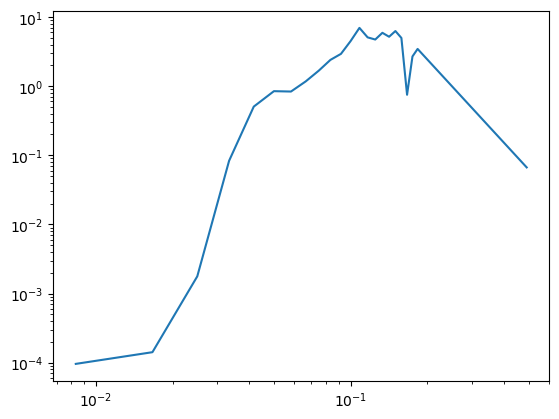

In [50]:
plt.loglog(fwindow, spec_store_sorted_new_corr[-1, :])

In [10]:
errors = np.load("/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/intermediate_processed_data/1hz_errors.npz", allow_pickle=True)

In [13]:
errors = errors['errors']

population std is:
0.016068364461868666
Min Hs =  0.6046110024028403


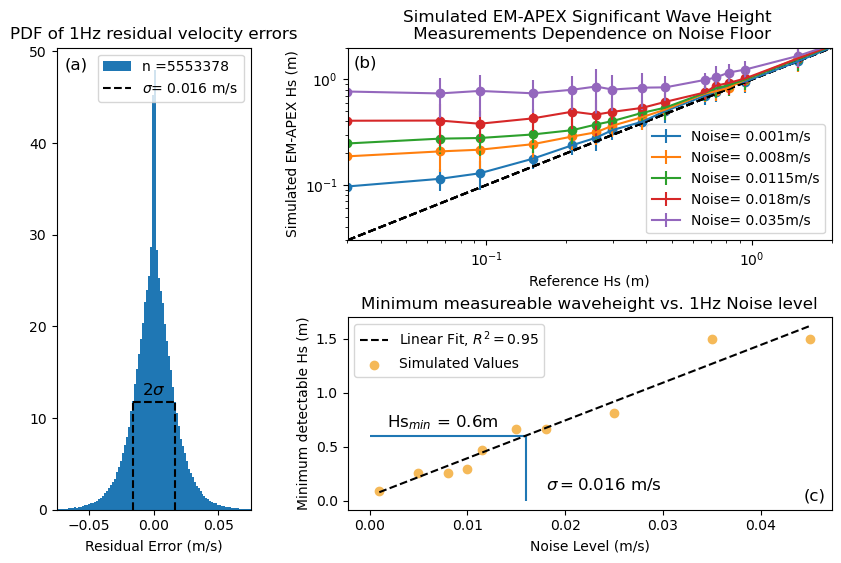

In [84]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 3)
gs.update(wspace=0.5)
gs.update(hspace=0.4)
plt.figure(figsize=(10,6))
ax1 = plt.subplot(gs[:, 0])
ax2 = plt.subplot(gs[0, 1:])
ax3 = plt.subplot(gs[1, 1:])



n, bins, patches = ax1.hist(errors[np.abs(errors)>0.0001], bins=200, density=True, label='n ='+str(len(errors)))
ax1.set_xlim([-0.075, 0.075])
#plt.ylim([0, 8000])
#print(np.nanmean(errors_store))
#plt.vlines(x=0.015, ymin = 0, ymax=26000)
ax1.set_xlabel("Residual Error (m/s)")
#print(np.nanstd(errors_store)/np.sqrt(len(errors_store)))
#np.nanmean(errors_store)
#np.max(n)/2
print("population std is:")
#print(np.sqrt(np.nansum(errors_store)/(len(errors_store)-1)))
#.02*.02
#print(np.sqrt(np.nanmean(var_store)))

print(np.nanstd(errors))
x=np.linspace(-0.1,
                0.11, 1000)
# )
#ax3.plot(x, scipy.stats.norm.pdf(x, 0,np.nanstd(errors_store)))
ax1.set_title("PDF of 1Hz residual velocity errors")

ax1.vlines(x=np.nanstd(errors),ymin=0, ymax=11.7, linestyle='--',color='k', label=r'$\sigma$= '+str(round(np.nanstd(errors), 3))+r' m/s')
ax1.vlines(x=-np.nanstd(errors),ymin=0, ymax=11.7, linestyle='--', color='k')
ax1.hlines(y=11.7, xmin =-np.nanstd(errors), xmax=np.nanstd(errors), linestyle='--', color='k' )
ax1.annotate(text=r'2$\sigma$', xy=(0,12.5), fontsize=12, ha="center")
ax1.legend()



#plt.figure()
#plt.subplot(211)
for noise in noise_levels[0::2]:
    
    ax2.scatter(Hs_cdip, df['Hs'][str(noise)])
    ax2.errorbar(Hs_cdip, df['Hs'][str(noise)], yerr = 2*df['Hs_stdev'][str(noise)], label="Noise= "+str(noise) + "m/s")
    ax2.set_xlim([0.03, 2])
    ax2.set_ylim([0.03, 2])
    #plt.plot(Hs_cdip)
    y = np.linspace(0, 5, 20)
    ax2.plot(y, y, 'k--')
    ax2.set_xscale('log')
    ax2.set_yscale('log')    
    ax2.set_xlabel("Reference Hs (m)")
    ax2.set_ylabel("Simulated EM-APEX Hs (m)")
    ax2.legend(loc='lower right')#loc=[1.1, 0.3])

    ax2.set_title("Simulated EM-APEX Significant Wave Height \n Measurements Dependence on Noise Floor")

# plt.figure()
# noise = 0.016
# plt.scatter(Hs_cdip, df['Hs'][str(noise)])
# plt.errorbar(Hs_cdip, df['Hs'][str(noise)], yerr = 2*df['Hs_stdev'][str(noise)], label="Noise= "+str(noise) + "m/s")
# plt.plot(y, y, 'k--')
# plt.vlines(x=min_Hs, ymin=0, ymax=df['Hs'][str(noise)][agreement_inds[0]], color='k')
# plt.xlim([0.03, 2])
# plt.ylim([0.03, 2])
# plt.text(0.5, 0.04, "Minimum Hs= "+str(round(min_Hs, 2))+"m")
# plt.xscale('log')
# plt.yscale('log')    
# plt.xlabel("Reference Hs (m)")
# plt.ylabel("Simulated EM-APEX Hs (m)")
# plt.legend()
# plt.title("Simulated EM-APEX Hs Measurements at Observed Noise Level")
# plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/JTECH_Paper/Minimum_wave_height.png")
# min_Hs_store = np.array([])
# for noise in noise_levels:
#     #Minimum significant wave height is:
#     agreement_inds = np.where(df['Hs'][str(noise)]-2*df['Hs_stdev'][str(noise)]<Hs_cdip)[0]
#     min_Hs_store = np.append(min_Hs_store, Hs_cdip[agreement_inds[0]])
#     #print("Min Hs = ", min_Hs,"m")
    
#plt.figure()

#Fit to scatter
[m, b], resid, rank, sing, rcond = np.polyfit(noise_levels, min_Hs_store, 1, full=True)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(noise_levels, min_Hs_store)
x=np.array(noise_levels)
ax3.plot(x, slope*x+intercept, '--k', label=r"Linear Fit, $R^2 = $" + str(round(r_value**2, 2)))
ax3.scatter(noise_levels, min_Hs_store, label="Simulated Values", color=cdip_color)
ax3.set_xlabel("Noise Level (m/s)")
ax3.set_ylabel("Minimum detectable Hs (m)")
ax3.set_title("Minimum measureable waveheight vs. 1Hz Noise level")
ax3.legend()
ax3.vlines(x=0.016, ymin=0, ymax=m*0.016+b)
ax3.hlines(y=m*0.016+b, xmin=0, xmax=0.016)
ax3.annotate(text=r'$\sigma = 0.016$ m/s', xy=(0.018, 0.1), fontsize=12, ha="left")
ax3.annotate(text=r'Hs$_{min}$ = 0.6m', xy=(0.0075, 0.68), fontsize=12, ha="center")


#Put letter labels
ax1.annotate(text='(a)', xy=(-0.06, 48), fontsize=12, ha="center")
ax2.annotate(text='(b)', xy=(0.035, 1.3), fontsize=12, ha="center")
ax3.annotate(text='(c)', xy=(0.0455, 0), fontsize=12, ha="center")



plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/JTECH_Paper/Minimum_wave_height_w_hist.png", bbox_inches='tight')

#plt.xlim([])
#ax2.show()
#ax2.savefig()

print("Min Hs = ", m*0.016+b)



In [1]:
Hs_cdip

NameError: name 'Hs_cdip' is not defined

In [8]:
fname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/229p1_d01.nc"
[times, f, spectra] = load_CDIP(fname)
base_spectra = np.nanmean(spectra[450:465, :], 0)

kk_arr = [0.0001, 0.0005, 0.001, 0.0025, 0.005, 0.0075, 0.01, 0.0167, 0.025, 0.05, 0.06, 0.075, 0.1, 0.25, 0.5, 0.75, 1]


Hs_cdip = 4*np.sqrt(np.trapz(np.tile(kk_arr, (64, 1)).T*np.tile(base_spectra, (len(kk_arr), 1)), x=f))

Hs_cdip


array([0.02984129, 0.06672715, 0.09436644, 0.14920644, 0.21100977,
       0.25843313, 0.29841288, 0.38563442, 0.47183219, 0.66727148,
       0.73095928, 0.81723732, 0.94366438, 1.49206439, 2.11009769,
       2.58433132, 2.98412877])

In [12]:
max(Hs_cdip)

2.984128771927218

In [11]:
len(kk_arr)

17